## EMG Signal Analysis: From Acquisition to Processing

### Introduction to EMG
Electromyography (EMG) measures electrical activity produced by skeletal muscles - it's like listening to your muscles talk! This notebook will show you:

- How to collect muscle signals in real-time
- What raw EMG data looks like
- How to clean up the signals
- How to see when muscles are working
- Checking your muscle strength

### Getting Ready
First, we need some Python libraries. If you haven't installed them yet, run:
```
pip install -r requirements.txt
```
Then, these libraries can be imported.

In [29]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# Import necessary libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
from helper.chords_usb import Chords_USB
from IPython.display import display, clear_output
import pandas as pd
import scipy.signal as signal
from pyqtgraph.Qt import QtWidgets, QtCore
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
from PyQt5 import QtWidgets, QtCore
from scipy import signal
import time

#### Here, the data streaming starts.

In [31]:
# This cell initializes the Chords_USB client, checks for compatible hardware, and starts the data streaming process.
client = Chords_USB()

if not client.detect_hardware():
    raise Exception("Could not detect compatible hardware")

client.send_command('START')
print("Streaming started...")

Trying COM25 at 230400...
NPG-LITE detected at COM25 with baudrate 230400
Streaming started...


### Getting Connected
#### Setting Up the Hardware
We'll connect to our device through a USB cable. Some devices can also connect wirelessly.

**Pro Tip:** For better signals:
1. Clean the skin with alcohol swab.

For more information checkout [skin prepration guide section](https://docs.upsidedownlabs.tech/guides/usage-guides/skin-preparation/index.htm) on documentation site.

2. Place electrodes like this:

<img src="assets/ecg.png" alt="Electrode Placement" width="200">

### Collecting Muscle Signals
Let's record 15 seconds of muscle activity! During this time:
- Try making a fist
- Try relaxing your arm
- Watch the live signals appear!

**Settings:**
- Recording time: 15 seconds
- Sampling rate: 250/500 Hz depending on the development board
- Smooth animation: 5 updates per second

## Understanding the Raw Signals
The first graph shows the raw muscle signals - they probably look very wiggly! This is normal because:
- Muscles make complex electrical patterns
- There's always some electrical noise around us

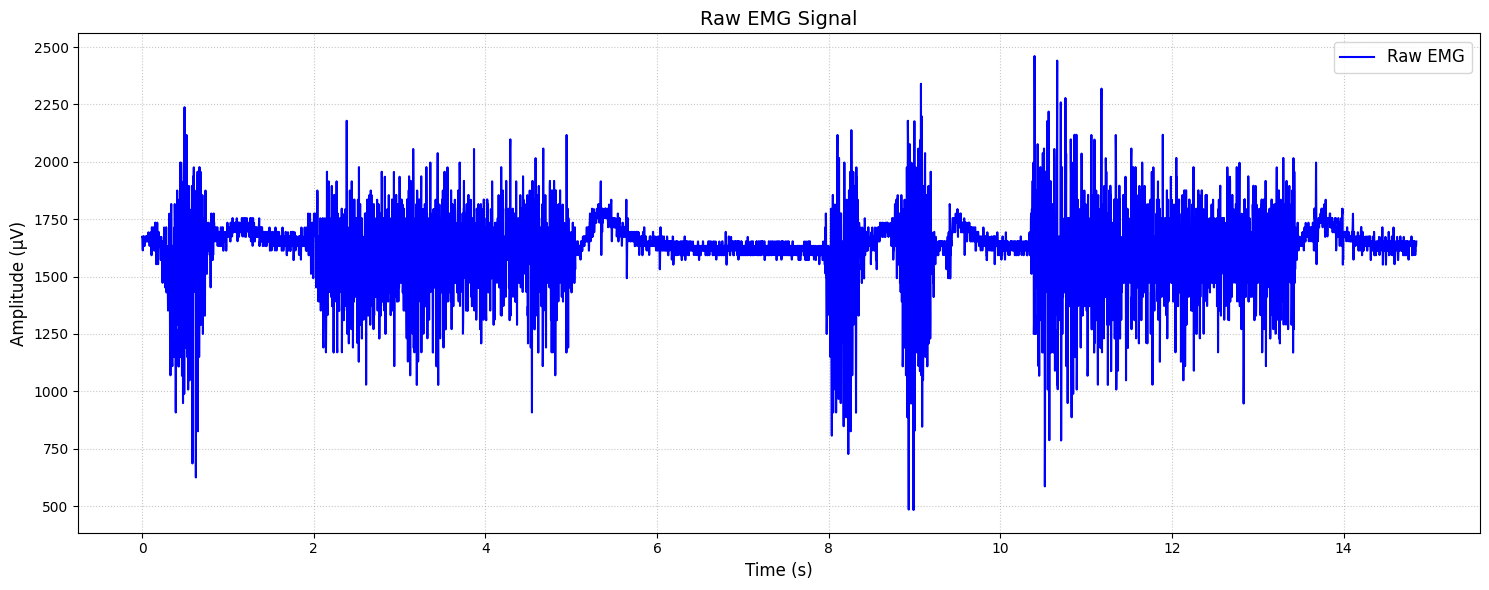

Data acquisition complete.


In [32]:
# Real-time EMG data acquisition with live plotting and plotting of raw signal as output
duration = 15
sampling_rate = client.supported_boards[client.board]["sampling_rate"]
samples_per_update = 100
frames_per_second = 5
update_interval = 1 / frames_per_second
window_seconds = 15
window_samples = int(window_seconds * sampling_rate)
time_data = np.array([])
emg_data = np.array([])

# Set up interactive mode for live window only
%matplotlib qt5
plt.ion()

# Create figure for live window
fig_window, ax_window = plt.subplots(figsize=(12, 6))
fig_window.canvas.manager.window.setWindowTitle('Real-time EMG Acquisition')

win = fig_window.canvas.manager.window
win.setWindowFlags(win.windowFlags() | QtCore.Qt.WindowStaysOnTopHint)
win.show()

# Configure plot
ax_window.set_title('Real-time EMG Signal')
ax_window.set_xlabel('Time (s)')
ax_window.set_ylabel('Amplitude')
ax_window.grid(True)
ax_window.set_ylim(0, 3000)
plt.tight_layout()

line_window, = ax_window.plot([], [], 'b-')
start_time = time.time()
last_update = start_time

# Real-time acquisition loop
while time.time() - start_time < duration:
    client.read_data()
    
    if client.data is not None:
        new_samples = client.data[0, :]
        current_time = time.time()
        if current_time - last_update >= update_interval:
            samples_to_take = min(samples_per_update, len(new_samples))
            if samples_to_take > 0:
                new_emg = new_samples[-samples_to_take:]
                new_time = np.linspace(current_time - samples_to_take/sampling_rate, current_time, samples_to_take, endpoint=False)
                
                valid_mask = np.isfinite(new_emg)
                new_emg = new_emg[valid_mask]
                new_time = new_time[valid_mask]
                
                if len(new_emg) > 0:
                    time_data = np.concatenate((time_data, new_time))
                    emg_data = np.concatenate((emg_data, new_emg))
                    
                    valid_mask = np.isfinite(emg_data) & np.isfinite(time_data)
                    emg_data = emg_data[valid_mask]
                    time_data = time_data[valid_mask]
                    
                    cutoff_time = current_time - window_seconds
                    keep_mask = time_data >= cutoff_time
                    time_data = time_data[keep_mask]
                    emg_data = emg_data[keep_mask]
                    
                    if len(time_data) > 0 and len(emg_data) > 0:
                        relative_time = time_data - start_time
                        line_window.set_data(relative_time, emg_data)
                        ax_window.set_xlim(max(0, relative_time[-1] - window_seconds), max(window_seconds, relative_time[-1]))
                        fig_window.canvas.draw()
                        fig_window.canvas.flush_events()
                
                last_update = current_time

plt.close(fig_window)
plt.ioff()

# Plot raw data in Output
%matplotlib inline
plt.figure(figsize=(15, 6))
plt.plot(time_data - start_time, emg_data, 'b-', linewidth=1.5, label='Raw EMG')
plt.title('Raw EMG Signal', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print("Data acquisition complete.")

### EMG Signal Processing - Cleaning Up the Signal
We'll use filters to clean the raw signals:

1. **Notch Filter**: Removes 50/60Hz powerline interference
2. **High-Pass Filter**: Cuts off slow movement artifacts (>70Hz)
3. **Envelope Detection**: Shows muscle activation patterns

#### CSV File
Then, at the end the data is saved as CSV File in the csv folder with file name emg_data.

Filtered data saved as 'CSV_Files\emg_data.csv'


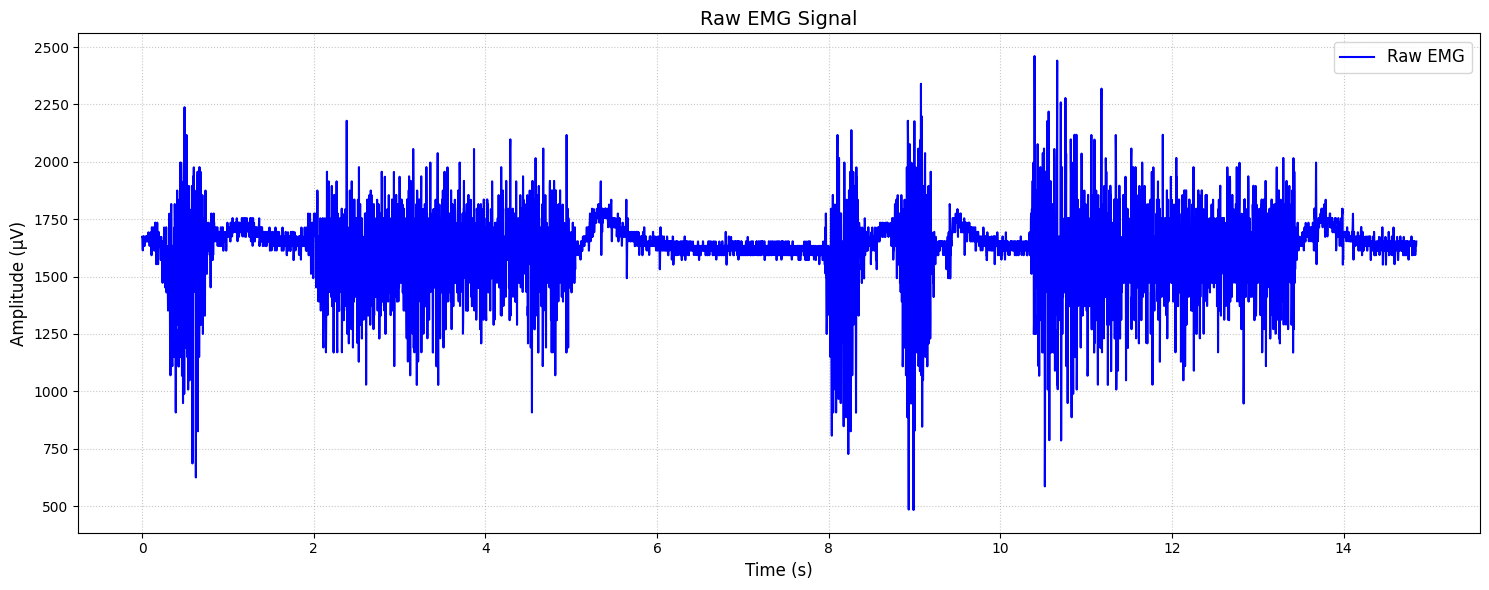

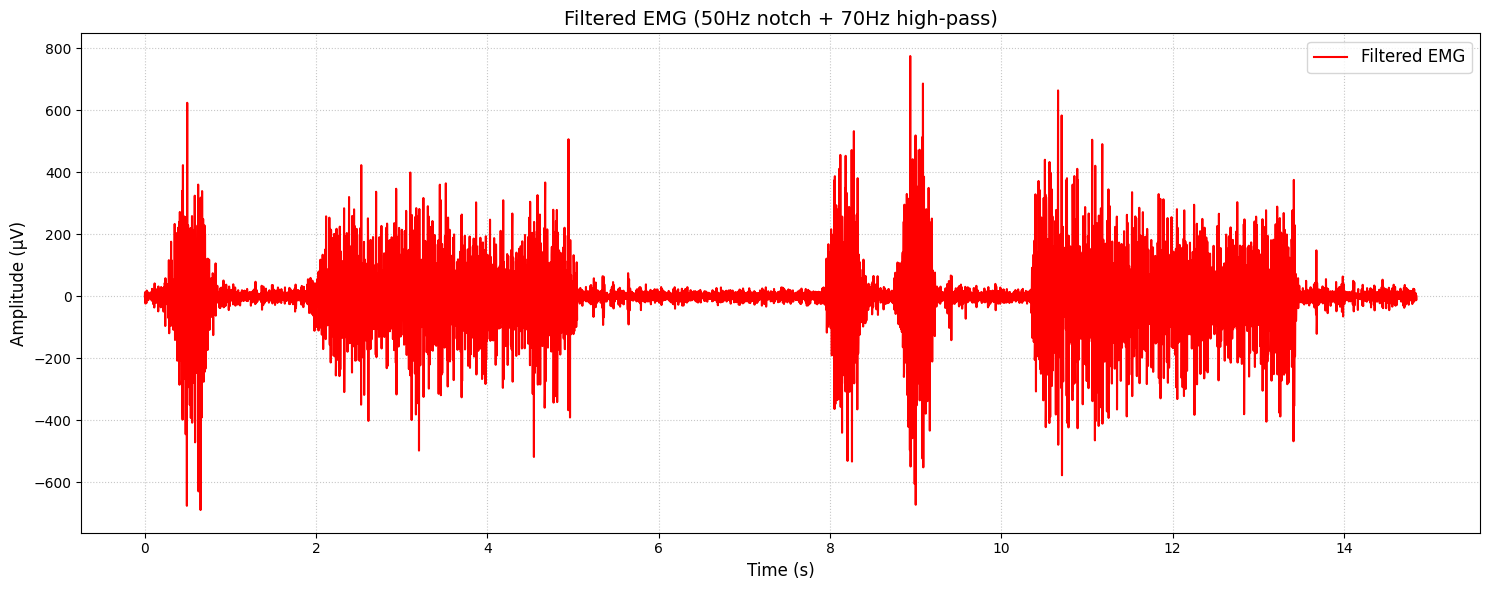

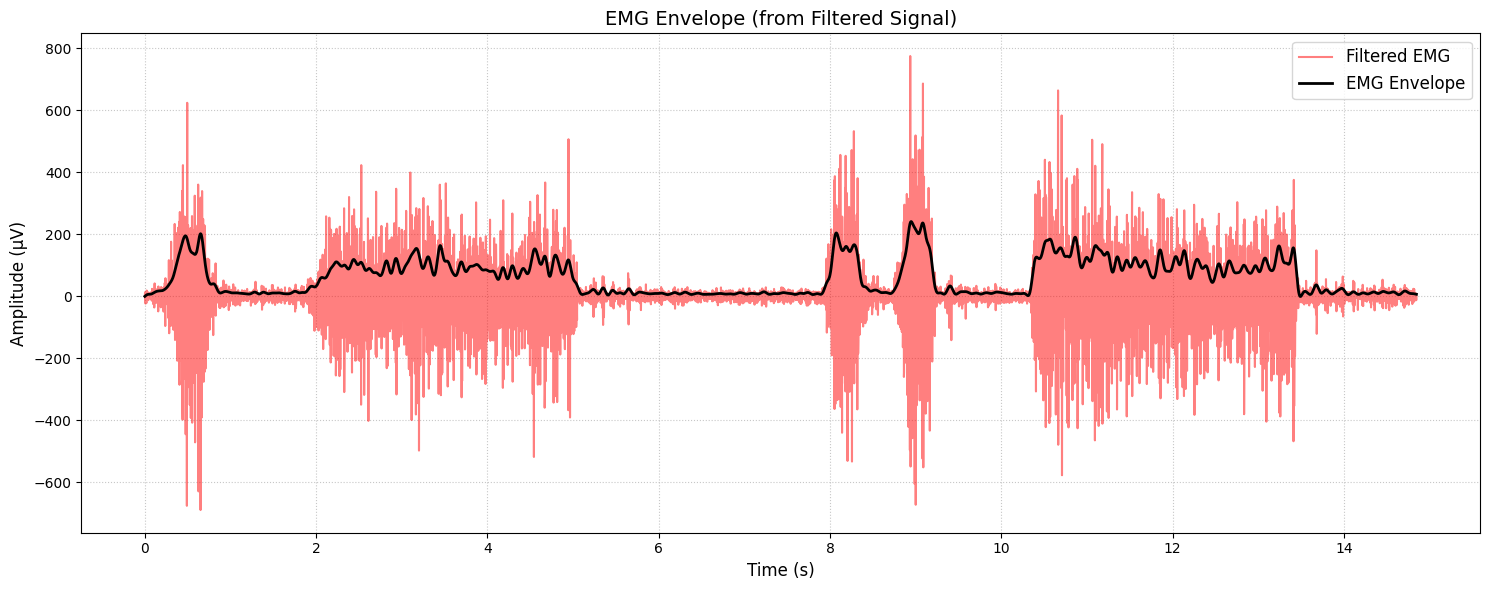

In [33]:
# This cell processes the acquired EMG data by applying notch and high-pass filters, saves the results to a CSV file, and visualizes raw and filtered signals and Envelope.
%matplotlib inline
time_axis = time_data - start_time

def notch_filter(data, fs, freq=50.0, quality_factor=30.0):
    nyq = 0.5 * fs
    freq = freq / nyq
    b, a = signal.iirnotch(freq, quality_factor)
    return signal.filtfilt(b, a, data)

def highpass_filter(data, fs, cutoff=70.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return signal.filtfilt(b, a, data)

def compute_emg_envelope(signal_data, fs, cutoff=10.0, order=4):
    rectified = np.abs(signal_data)

    # Low-pass filter
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    envelope = signal.filtfilt(b, a, rectified)
    return envelope

# Apply filters
emg_notch = notch_filter(emg_data, sampling_rate, freq=50.0)
emg_filtered = highpass_filter(emg_notch, sampling_rate, cutoff=70.0)

# Create DataFrame
emg_df = pd.DataFrame({'Time (s)': time_axis,'Raw_EMG': emg_data,'Notch_Filtered_50Hz': emg_notch,'HighPass_Filtered_70Hz': emg_filtered})

output_folder = 'CSV_Files'
os.makedirs(output_folder, exist_ok=True)
csv_filename = os.path.join(output_folder, 'emg_data.csv')
emg_df.to_csv(csv_filename, index=False)
print(f"Filtered data saved as '{csv_filename}'")

# Compute envelope of the filtered EMG signal
emg_envelope = compute_emg_envelope(emg_filtered, sampling_rate)
emg_df['EMG_Envelope'] = emg_envelope        # Add envelope to DataFrame
emg_df.to_csv(csv_filename, index=False)     # Save updated DataFrame with envelope

# Plot raw signal
plt.figure(figsize=(15, 6))
plt.plot(time_axis, emg_data, 'b-', linewidth=1.5, label='Raw EMG')
plt.title('Raw EMG Signal', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot filtered signal
plt.figure(figsize=(15, 6))
plt.plot(time_axis, emg_filtered, 'r-', linewidth=1.5, label='Filtered EMG')
plt.title('Filtered EMG (50Hz notch + 70Hz high-pass)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot envelope
plt.figure(figsize=(15, 6))
plt.plot(time_axis, emg_filtered, 'r-', alpha=0.5, label='Filtered EMG')
plt.plot(time_axis, emg_envelope, 'k-', linewidth=2, label='EMG Envelope')
plt.title('EMG Envelope (from Filtered Signal)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Muscle Strength Display
Now the fun part - a live muscle strength monitor! For 30 seconds you'll see:
- A color that changes from green (relaxed) to red (strong contraction)
- The peak strength you reached

**Challenge:** Can you make the meter turn red and hold it there?

In [34]:
app = QtWidgets.QApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)

# Create figure without the default matplotlib toolbar
plt.ioff()
fig = plt.figure(figsize=(10, 2), tight_layout=True)
canvas = FigureCanvasQTAgg(fig)
ax = fig.add_subplot(111)

# Configure window
canvas.setWindowTitle("EMG Strength Meter")
canvas.setWindowFlags(QtCore.Qt.Window | QtCore.Qt.CustomizeWindowHint | QtCore.Qt.WindowTitleHint | QtCore.Qt.WindowStaysOnTopHint)

# Center window on screen
screen_geometry = QtWidgets.QDesktopWidget().screenGeometry()
window_size = canvas.size()
canvas.move((screen_geometry.width() - window_size.width()) // 2, (screen_geometry.height() - window_size.height()) // 2)

# Configure the plot
ax.set_xlim(0, 700)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_xlabel('Muscle Activation Level (Envelope Amplitude)')
ax.grid(True, axis='x')

# Create the strength bar
strength_bar = ax.barh(0, 0, height=0.6, color='green', alpha=0.6)
max_level = 0

# Parameters
window_size = 100
update_interval = 0.1
duration = 30
fs = 500           # Sampling Rate
hp_cutoff = 70.0   # High-pass cutoff (70 Hz)
lp_cutoff = 10.0   # Low-pass cutoff for envelope
order = 4

# Show the window
canvas.show()

def apply_highpass(signal_data, fs, cutoff=70.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return signal.filtfilt(b, a, signal_data)

def compute_emg_envelope(signal_data, fs, cutoff=10.0, order=4):
    rectified = np.abs(signal_data)
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, rectified)

start_time = time.time()
last_update = start_time
emg_buffer = []

try:
    while time.time() - start_time < duration:
        client.read_data()
        
        if client.data is not None:
            new_samples = client.data[0, :]
            emg_buffer.extend(new_samples)
            
            if len(emg_buffer) > window_size:
                emg_buffer = emg_buffer[-window_size:]
            
            current_time = time.time()
            if current_time - last_update >= update_interval:
                if len(emg_buffer) >= window_size:
                    # 1. Apply high-pass filter first
                    filtered_emg = apply_highpass(np.array(emg_buffer), fs, hp_cutoff, order)
                    # 2. Then compute envelope
                    envelope = compute_emg_envelope(filtered_emg, fs, lp_cutoff, order)
                    
                    envelope_mean = np.mean(envelope)
                    max_level = max(max_level, envelope_mean)
                    
                    strength_bar[0].set_width(envelope_mean)
                    
                    if envelope_mean > 600:
                        strength_bar[0].set_color('red')
                    elif envelope_mean > 400:
                        strength_bar[0].set_color('orange')
                    elif envelope_mean > 200:
                        strength_bar[0].set_color('yellow')
                    else:
                        strength_bar[0].set_color('green')
                    
                    if 'peak_line' in locals():
                        peak_line.remove()
                    peak_line = ax.axvline(max_level, color='r', linestyle='--', alpha=0.5)
                    ax.set_title(f'Current: {envelope_mean:.1f} | Peak: {max_level:.1f}')
                    
                    canvas.draw()
                    app.processEvents()
                
                last_update = current_time

except KeyboardInterrupt:
    pass

canvas.close()
plt.close('all')
if QtWidgets.QApplication.instance():
    QtWidgets.QApplication.quit()

print(f"Maximum peak value: {max_level:.1f}")

Maximum peak value: 321.7


In [35]:
# Send STOP command to terminate data acquisition
client.send_command('STOP')
print("Streaming stopped")

Streaming stopped


### Summary and Key Takeaways

Through this notebook we learned:
1. EMG signals contain valuable information about muscle activity
2. Proper filtering is essential for clean signals
3. The envelope represents muscle activation
4. About our muscle strength

🔧 Experiment & Explore:
1. Recording Time – Shorter (5 sec) for quick tests, longer (30 sec) for endurance.
2. Filter Tweaks – Adjust frequencies to see how signals change.
3. New Muscles – Test forehead (frowning), calves (standing on toes), or jaw (clenching).

### Quick Troubleshooting Guide

⚠️ **Problem: No Signal?**  
🔧 **Fix:** Check USB/wireless connection → Ensure electrodes are sticky  
⚠️ **Problem: Too Noisy?**  
🔧 **Fix:** Rub skin with alcohol first → Stay still during recording  
⚠️ **Problem: Weird Signal Jumps?**  
🔧 **Fix:** Avoid interference → Tighten electrode wires

For more information checkout [guide section](https://docs.upsidedownlabs.tech/guides/troubleshoot/tips/index.html) on documentation site.